In [1]:
# import libraries
%matplotlib inline

import numpy as np                          # General math operations
import scipy.io as sio                      # Loads .mat variables
import matplotlib.pyplot as plt             # Data visualization
import math
from pyeasyga import pyeasyga               # Genetic algorithms
import random                               # RNG for GA implementation

class expData (object):
    fuzzyLookupTable = 0
    def __init__(self, fileName):
        # Load dataset of the weather for typical meteorological months into a dictionary
        dataset = sio.loadmat(fileName)
        self.cad = dataset['cad']          # Cadance
        self.heart = dataset['heart']         # Heart Rate
        self.p = dataset['power']          # power
        self.torq = dataset['torq']      #torque
        self.time = dataset['time']       # Total number of data second
    def plotC (self):
        f, axarr = plt.subplots(3, sharex = True)
        axarr[0].plot(self.time, self.p)
        axarr[0].set_title('time vs power')
        axarr[1].plot(self.time, self.heart)
        axarr[1].set_title('time vs heart rate')
        axarr[2].plot(self.p, self.heart)
        axarr[2].set_title('power vs heart')
        plt.show()
        
    

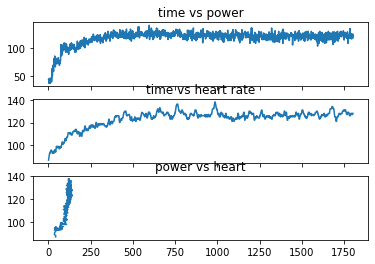

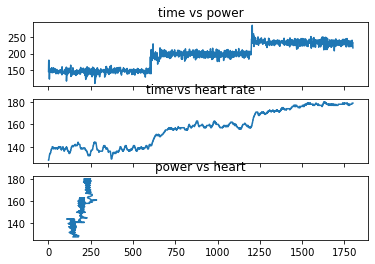

In [2]:
cP = expData('cHR_1124.mat')  
cP.plotC()
cP = expData('cP_1124.mat')  
cP.plotC()


In [3]:
def discDer(fn,step):
    der = np.zeros(len(fn))
    for n in range(len(fn)):
        if n ==0:
            der[n] = (fn[1]-fn[0])/step
        elif n<(len(fn)-1):
            der[n] = (fn[n+1]-fn[n-1])/(2*step)
        else:
            der[n] = fn[n]-fn[n-1]
    return der

def trapInt(f,step):
    S = np.zeros(len(f))
    for n in range (len(f)):
        intF = f[0:n+1]
        S[n] = spi.simps(intF)
    return S


In [4]:
#f = None
#u = None
def p2hr(filename,a1,a2,a3,a4,a5,a6,c):
        #global f,u
        cP = expData(filename)    

        # x1 = given data
        x1 = (cP.heart-cP.heart[0])/max(max(cP.heart))
        t = cP.time
        f = np.transpose(x1)[0]
        #print(f,x1)
        cPp = (cP.p-cP.p[0])/max(max(cP.p))
        u = np.transpose(cPp)[0]

        x1p = discDer(f,1)

        x1pEq = np.zeros(len(f))
        x1pR = np.zeros(len(f))

        # 
        for n in range(len(f)):
            x1pEq[n] = (a4*math.exp(a3*n)*f[n])/(math.exp(a5-f[n])+1) 

        intX1 = trapInt(x1pEq,1)

        for n in range(len(f)):
            x1pR[n] =-a1*f[n]+a2*(math.exp(-a3*n)*(x1pEq[n]+c))+a6*(u[n])

        resX1 = trapInt(x1pR,1)
        return [t,x1pR,x1pEq,resX1,x1]
        
def p2hrPlt(t,x1pR,x1pEq,resX1,x1) :       
        f, subplt = plt.subplots(2, sharex = True)
        subplt[0].plot(t,x1pR,label = 'xqpR')
        subplt[0].plot(t,x1pEq,label = 'x1pEq')
        subplt[0].legend()

        subplt[1].plot(t,resX1,label = 'resx1')
        subplt[1].plot(t,x1,label = 'x1')
        subplt[1].legend()
        
        RMSE = np.sqrt(np.sum((resX1 - x1) ** 2) / len(x1)) 
        print('RMSE is ',RMSE)

In [5]:
cP = expData('cHR_1124.mat')
max(max(cP.p))

142

RMSE is  5.141485490071188


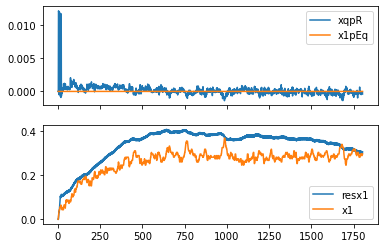

In [6]:
# ongoing
cP = p2hr('cHR_1124.mat',a1 = 0.0139, a2 = 0.072, a3 = 0.0049, a4 = 0.0041, a5 = 19.8002, a6 = 0.006999,c=0)
p2hrPlt(cP[0],cP[1],cP[2],cP[3],cP[4])

RMSE is  5.141485490071188


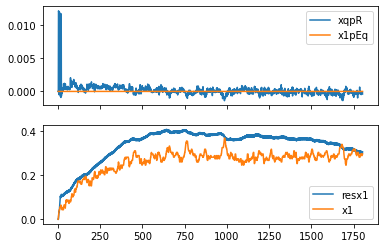

In [7]:
# tmp
cP = p2hr('cHR_1124.mat',a1 = 0.0139, a2 = 0.072, a3 = 0.0049, a4 = 0.0041, a5 = 19.8002, a6 = 0.006999,c=0)
p2hrPlt(cP[0],cP[1],cP[2],cP[3],cP[4])

In [8]:
def create_individual():
    """ Create a candidate solution representation
        Represented as an array of a1 to a6 and c with different intervals 
    """
    individual = np.zeros((7,))
    individual[0] = random.uniform(0, 0.0140)  # a1 value
    individual[1] = random.uniform(0, 0.1)  # a2 value
    individual[2] = random.uniform(0, 0.1)  # a3 value
    individual[3] = random.uniform(0, 0.1)  # a4 value
    individual[4] = random.uniform(0, 20)  # a5 value
    individual[5] = random.uniform(0, 0.10)  # a6 value
    individual[6] = random.uniform(0, 0.10)  # c value
    return individual

def crossover(parent_1, parent_2):
    """ Crossover two parents to produce two children
        Performs a weighted arithmetic recombination
    """
    ratio = random.uniform(-1, 1)  # Generate a number from -1 to 1
    crossIndices = np.random.choice([0, 1], size=(len(parent_1),), p=[0.5, 0.5])  # Determine if x and/or y value is operated on
    child_1 = parent_1
    child_2 = parent_2
    for i in range(len(crossIndices)):
        if (crossIndices[i] == 1):
            child_1[i] = child_1[i] + ratio * child_2[i]  # Perform weighted sum
            child_2[i] = child_2[i] + ratio * child_1[i]
    return child_1, child_2

def mutate(individual):
    """ Mutate an individual to introduce new genetic information to the population
        Adds a random number from 0 to 9 to each allele in the individual (up to two decimal places)
    """
    mutateIndices = np.random.choice([0, 1], size=(4,), p=[0.8, 0.2])
    for index in range(len(mutateIndices)):
        if(mutateIndices[index] == 1):
            individual[0] += random.randint(1, 9) * (10**(index - 5))  # a1 value
            individual[1] += random.randint(1, 9) * (10**(index - 5))  # a2 value
            individual[2] += random.randint(1, 9) * (10**(index - 5))  # a3 value
            individual[3] += random.randint(1, 9) * (10**(index - 5))  # a4 value
            individual[4] += random.randint(1, 9) * (10**(index - 5))  # a5 value
            individual[5] += random.randint(1, 9) * (10**(index - 5))  # a6 value
            individual[6] += random.randint(1, 9) * (10**(index - 5))  # c value

def fitness(individual):
    """ Calculate fitness of a candidate solution representation
    """
    a1  = individual[0]
    a2  = individual[1]
    a3  = individual[2]
    a4  = individual[3]
    a5  = individual[4]
    a6  = individual[5]
    c  = individual[6]
    filename = 'cHR_1124.mat'
    cP = p2hr(filename,a1,a2,a3,a4,a5,a6,c)
    fitness = np.sqrt(np.sum((cP[3] - cP[4]) ** 2) / len(cP[4]))
    return fitness

In [42]:
def rankPop(array):
    fitness = []
    resArray = []
    
    for i in range(len(array)):
        fitness.append(array[i][2])
        
    for i in range(len(array)):
        ind = fitness.index(min(fitness))
        resArray.append([ind,array[ind][1],min(fitness)])
        fitness[ind] =max(fitness)
    return resArray

In [43]:
#create initial population
population = 30

pop = []
popFit = []
resPop = []
ranPop = []
for i in range(population):
    pop.append(create_individual())
    popFit.append(fitness(pop[i]))
    resPop.append([i,pop[i],popFit[i]])

ranPop.append(rankPop(resPop))



inputData = np.random.rand(1801,1801)

ga = pyeasyga.GeneticAlgorithm(
    inputData,
    population_size = 30,
    generations = 50,
    crossover_probability = 0.8,
    mutation_probability = 0.005,
    maximise_fitness = False 
)
ga.create_individual = create_individual
ga.crossover_function = crossover
ga.mutate_function = mutate
ga.selection_function = ga.tournament_selection
ga.fitness_function = fitness

ga.run()
bestSoln = ga.best_individual()
print("Fitness = ",bestSoln[0], "Solution = ",bestSoln[1])
# print("Solution = ",bestSoln[1])

In [16]:
create_individual()

array([1.26099531e-02, 4.51275072e-02, 8.92865784e-02, 1.85370100e-02,
       1.36066064e+01, 3.70070747e-02, 1.79953645e-02])